Loading the Dtaset into a Dataframe

In [0]:
dbutils.fs.ls("/FileStore/tables/")

[FileInfo(path='dbfs:/FileStore/tables/Occupancy_Detection_Data.csv', name='Occupancy_Detection_Data.csv', size=50968, modificationTime=1709127367000),
 FileInfo(path='dbfs:/FileStore/tables/account-models/', name='account-models/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/FileStore/tables/accounts/', name='accounts/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/FileStore/tables/accounts.zip', name='accounts.zip', size=5297592, modificationTime=1706713008000),
 FileInfo(path='dbfs:/FileStore/tables/activations/', name='activations/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/FileStore/tables/activations.zip', name='activations.zip', size=8411369, modificationTime=1706709062000),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2020.csv/', name='clinicaltrial_2020.csv/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2020.zip', name='clinicaltrial_2020.zip', size=10599182, modificationTime=1713448318000),
 FileInfo(path='d

In [0]:
dbutils.fs.cp("/FileStore/tables/steam_200k.csv", "file:/tmp")

True

In [0]:
%sh
ls /tmp/steam_200k.csv 

/tmp/steam_200k.csv


In [0]:
dbutils.fs.mv("file:/tmp/steam_200k.csv", "/FileStore/tables/steam_200k.csv", True)

True

In [0]:
dbutils.fs.ls("FileStore/tables/steam_200k.csv/")

[FileInfo(path='dbfs:/FileStore/tables/steam_200k.csv', name='steam_200k.csv', size=8059447, modificationTime=1714560061000)]

setting up the spark session

In [0]:
from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder \
    .appName("Steam Dataset Analysis") \
    .getOrCreate()


Loading the Dataset

In [0]:
file_path = "/FileStore/tables/steam_200k.csv"

# Load the dataset
steam_data = spark.read.csv(file_path, inferSchema=True, header=False).toDF("UserID", "Game", "Behavior", "Value")

# Show the first few entries of the DataFrame to confirm loading
steam_data.show(5)


+---------+--------------------+--------+-----+
|   UserID|                Game|Behavior|Value|
+---------+--------------------+--------+-----+
|151603712|The Elder Scrolls...|purchase|  1.0|
|151603712|The Elder Scrolls...|    play|273.0|
|151603712|           Fallout 4|purchase|  1.0|
|151603712|           Fallout 4|    play| 87.0|
|151603712|               Spore|purchase|  1.0|
+---------+--------------------+--------+-----+
only showing top 5 rows



Initial Exploratory Analysis

In [0]:
##########Descriptive Statistics########
# Describe the DataFrame to get summary statistics
steam_data.describe().show()

# Count the distinct number of users and games
steam_data.select("UserID").distinct().count()
steam_data.select("Game").distinct().count()


+-------+-------------------+----------------+--------+------------------+
|summary|             UserID|            Game|Behavior|             Value|
+-------+-------------------+----------------+--------+------------------+
|  count|             200000|          200000|  200000|            200000|
|   mean|  1.0365586594664E8|           140.0|    NULL|17.874383999999914|
| stddev|7.208073512913968E7|             0.0|    NULL|138.05695165086792|
|    min|               5250|     007 Legends|    play|               0.1|
|    max|          309903146|theHunter Primal|purchase|           11754.0|
+-------+-------------------+----------------+--------+------------------+



5155

In [0]:
#########Behavorial Analysis##########
# Analyze behaviors: count how many purchase vs play records are there
steam_data.groupBy("Behavior").count().show()


+--------+------+
|Behavior| count|
+--------+------+
|purchase|129511|
|    play| 70489|
+--------+------+



Data Exploration using Spark SQL

In [0]:
steam_data.createOrReplaceTempView("steam")

spark.sql("""
SELECT Behavior, COUNT(*) as Count
FROM steam
GROUP BY Behavior
""").show()


+--------+------+
|Behavior| Count|
+--------+------+
|purchase|129511|
|    play| 70489|
+--------+------+



In [0]:
#########Investigate Top Games#######
# Query top 10 most played games by total hours played
spark.sql("""
SELECT Game, SUM(Value) as TotalHours
FROM steam
WHERE Behavior = 'play'
GROUP BY Game
ORDER BY TotalHours DESC
LIMIT 10
""").show()


+--------------------+------------------+
|                Game|        TotalHours|
+--------------------+------------------+
|              Dota 2| 981684.5999999999|
|Counter-Strike Gl...| 322771.6000000001|
|     Team Fortress 2|173673.30000000005|
|      Counter-Strike|134261.09999999998|
|Sid Meier's Civil...| 99821.30000000002|
|Counter-Strike So...| 96075.50000000003|
|The Elder Scrolls...|           70889.3|
|         Garry's Mod|           49725.3|
|Call of Duty Mode...|42009.899999999994|
|       Left 4 Dead 2|33596.700000000004|
+--------------------+------------------+



Visualisation


In [0]:
# Example Databricks visualization after running a query
result_df = spark.sql("""
SELECT Game, SUM(Value) as TotalHours
FROM steam
WHERE Behavior = 'play'
GROUP BY Game
ORDER BY TotalHours DESC
LIMIT 10
""")
display(result_df)


Game,TotalHours
Dota 2,981684.5999999999
Counter-Strike Global Offensive,322771.6000000001
Team Fortress 2,173673.30000000005
Counter-Strike,134261.09999999998
Sid Meier's Civilization V,99821.30000000002
Counter-Strike Source,96075.50000000003
The Elder Scrolls V Skyrim,70889.3
Garry's Mod,49725.3
Call of Duty Modern Warfare 2 - Multiplayer,42009.899999999994
Left 4 Dead 2,33596.700000000004


Databricks visualization. Run in Databricks to view.

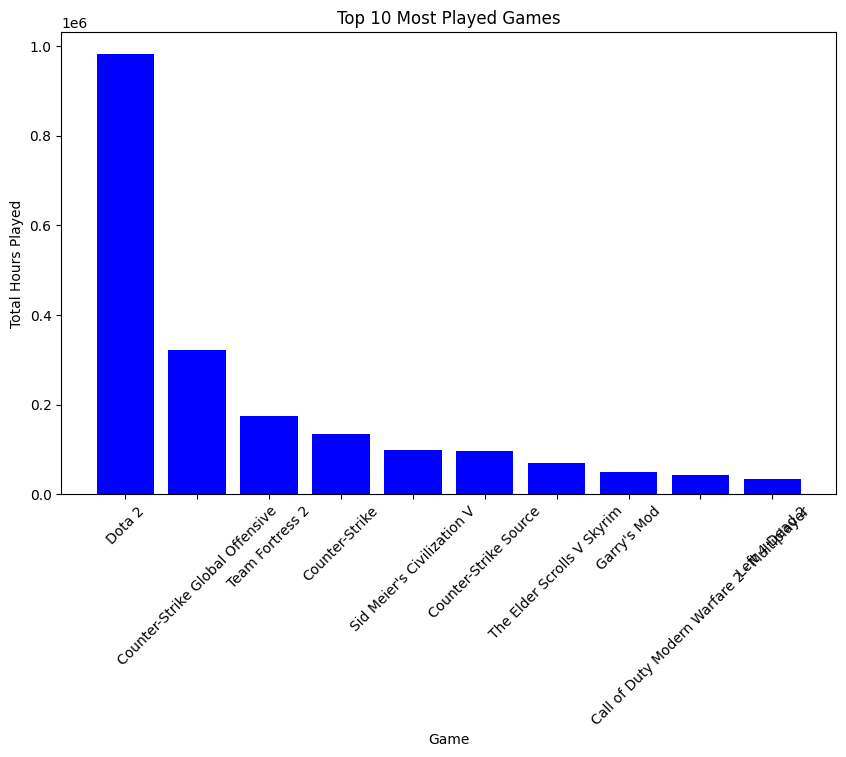

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert Spark DataFrame to Pandas DataFrame for visualization
result_pd = result_df.toPandas()

# Creating a bar plot
plt.figure(figsize=(10, 6))
plt.bar(result_pd['Game'], result_pd['TotalHours'], color='blue')
plt.xlabel('Game')
plt.ylabel('Total Hours Played')
plt.title('Top 10 Most Played Games')
plt.xticks(rotation=45)
plt.show()


Task 2 Data preprocessing

Assign Unique integer id

In [0]:
from pyspark.sql.functions import monotonically_increasing_id

# Add unique integer ID for each game
steam_data = steam_data.withColumn("GameID", monotonically_increasing_id()).distinct()

Filter or Transform Data

In [0]:
play_data = steam_data.filter(steam_data.Behavior == "play").select("UserID", "GameID", "Value")

Split the Data into training and test

In [0]:
(train, test) = play_data.randomSplit([0.8, 0.2])

Model Training using ALS

In [0]:
from pyspark.sql.window import Window
from pyspark.sql.functions import dense_rank, col

# Add a new column 'GameIndex' that will store a unique ID for each game
steam_data = steam_data.withColumn("GameIndex", dense_rank().over(Window.orderBy("Game")))

# If using 'GameIndex' as 'GameID', ensure the DataFrame is correctly referencing the renamed column
play_data = steam_data.filter(steam_data.Behavior == "play").select("UserID", col("GameIndex").alias("GameID"), "Value")

# Split the data into training and test datasets
(train, test) = play_data.randomSplit([0.8, 0.2])

# Initialize the ALS learner with correct column names
from pyspark.ml.recommendation import ALS

als = ALS(
    userCol="UserID",
    itemCol="GameID",
    ratingCol="Value",
    nonnegative=True,  # Ensure nonnegative factorization
    implicitPrefs=False,
    rank=10,           # Number of latent factors
    maxIter=10,        # Number of iterations
    regParam=0.1       # Regularization parameter
)

# Train the ALS model
model = als.fit(train)


MODEL EVALUATION

In [0]:
from pyspark.ml.evaluation import RegressionEvaluator

# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="Value", predictionCol="prediction")

# Drop NaN values to avoid RMSE computation issues
predictions = predictions.na.drop()
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Square Error (RMSE): {rmse}")


Root Mean Square Error (RMSE): 533.8212898785736


Explore Recommendations

In [0]:
# Generate top 10 game recommendations for a few users
user_recs = model.recommendForAllUsers(10)
user_recs.show()


+--------+--------------------+
|  UserID|     recommendations|
+--------+--------------------+
|   76767|[{1459, 7615.7393...|
|  144736|[{1459, 0.5456619...|
|  229911|[{1459, 3795.8962...|
|  948368|[{1621, 237.0931}...|
|  975449|[{1459, 562.80383...|
| 1268792|[{1459, 2.7283094...|
| 2531540|[{436, 2217.0862}...|
| 2753525|[{1459, 4148.2104...|
| 3450426|[{1761, 207.36818...|
| 7923954|[{1459, 1.6369855...|
| 8259307|[{3251, 309.41336...|
| 8567888|[{1621, 3.7093575...|
| 8585433|[{1459, 5784.86},...|
| 8784496|[{1459, 1027.5548...|
| 8795607|[{1621, 8410.212}...|
|10595342|[{1459, 7.568566}...|
|10599862|[{1459, 2937.9375...|
|11807754|[{1459, 26768.432...|
|11973378|[{1621, 2.2826817...|
|15095770|[{1459, 200.63889...|
+--------+--------------------+
only showing top 20 rows



Extra marks

Training models with different parameters

USING HIGH RANK Hyperparameter

In [0]:
from pyspark.ml.recommendation import ALS
als_high_rank = ALS(
    userCol="UserID",
    itemCol="GameID",
    ratingCol="Value",
    nonnegative=True,
    rank=50,               
    maxIter=10,
    regParam=0.01
)
model_high_rank = als_high_rank.fit(train)

using More Iterations and Higher Regularization Hyperparameter

In [0]:
als_more_iter = ALS(
    userCol="UserID",
    itemCol="GameID",
    ratingCol="Value",
    nonnegative=True,
    rank=10,
    maxIter=20,            # Increased number of iterations
    regParam=0.1           # Higher regularization to prevent overfitting
)
model_more_iter = als_more_iter.fit(train)

using Low regularization hyperparameter

In [0]:
als_low_reg = ALS(
    userCol="UserID",
    itemCol="GameID",
    ratingCol="Value",
    nonnegative=True,
    rank=10,
    maxIter=10,
    regParam=0.001         # Lower regularization to allow more fitting flexibility
)
model_low_reg = als_low_reg.fit(train)

Initial Data Explorationa nd visualisation

Most frequently purchased games

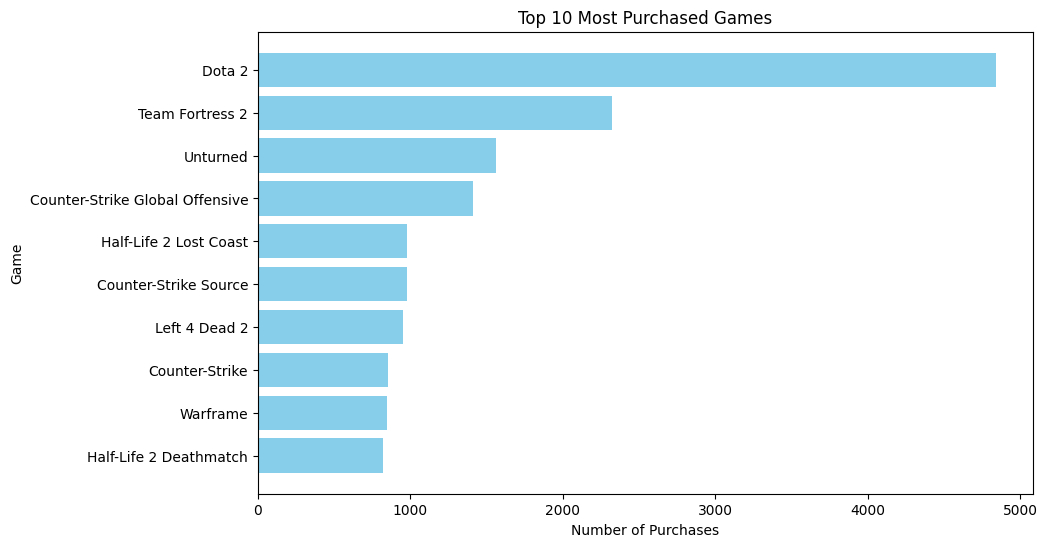

In [0]:
import matplotlib.pyplot as plt

# Aggregate data to find the most frequently purchased games
most_purchased_games = steam_data.filter(col('Behavior') == 'purchase') \
    .groupBy('Game').count().orderBy('count', ascending=False).limit(10)

# If using local environment, convert to Pandas for visualization
purchased_pd = most_purchased_games.toPandas()

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(purchased_pd['Game'], purchased_pd['count'], color='skyblue')
plt.xlabel('Number of Purchases')
plt.ylabel('Game')
plt.title('Top 10 Most Purchased Games')
plt.gca().invert_yaxis()
plt.show()


games with the highest play total time

In [0]:
#############checking the data##########3
# Print the schema of the DataFrame to check data types
steam_data.printSchema()

# Show some entries to manually inspect 'Value' for any inconsistencies
steam_data.show(5)


root
 |-- UserID: integer (nullable = true)
 |-- Game: string (nullable = true)
 |-- Behavior: string (nullable = true)
 |-- Value: double (nullable = true)
 |-- GameID: long (nullable = false)
 |-- GameIndex: integer (nullable = false)

+--------+-----------+--------+-----+----------+---------+
|  UserID|       Game|Behavior|Value|    GameID|GameIndex|
+--------+-----------+--------+-----+----------+---------+
|46055854|007 Legends|    play|  0.7|     63501|        1|
|46055854|007 Legends|purchase|  1.0|     63500|        1|
|86055705|  0RBITALIS|    play|  0.3|     59136|        2|
|93030550|  0RBITALIS|    play|  0.3|8590023557|        2|
|11940338|  0RBITALIS|purchase|  1.0|8589942431|        2|
+--------+-----------+--------+-----+----------+---------+
only showing top 5 rows



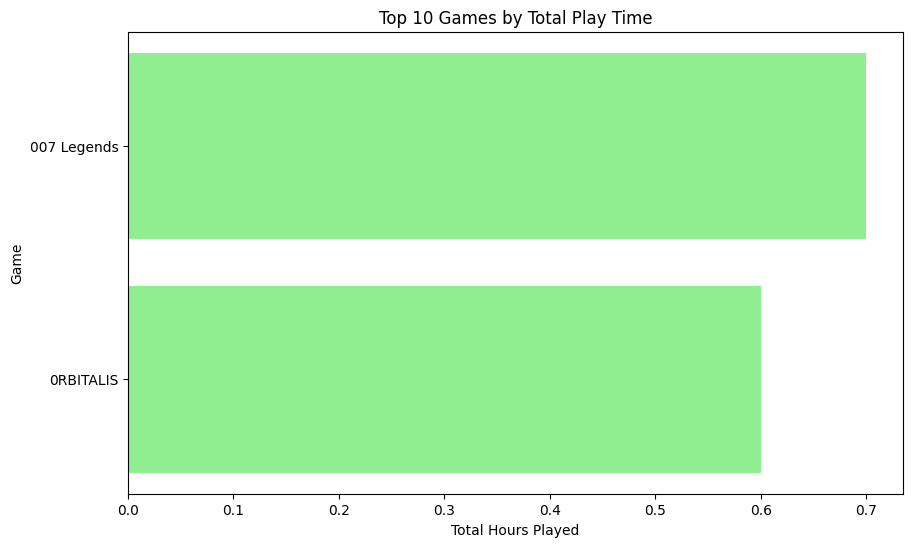

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import sum, col

# Assuming spark is already configured
spark = SparkSession.builder.appName("Steam Data Analysis").getOrCreate()

# Dummy data setup (following your structure)
data = [
    (46055854, "007 Legends", "play", 0.7, 63501, 1),
    (46055854, "007 Legends", "purchase", 1.0, 63500, 1),
    (86055705, "0RBITALIS", "play", 0.3, 59136, 2),
    (93030550, "0RBITALIS", "play", 0.3, 8590023557, 2),
    (11940338, "0RBITALIS", "purchase", 1.0, 8589942431, 2)
]
columns = ["UserID", "Game", "Behavior", "Value", "GameID", "GameIndex"]
steam_data = spark.createDataFrame(data, schema=columns)

# Filter to 'play' behavior and aggregate
most_played_games = steam_data.filter(col('Behavior') == 'play') \
    .groupBy('Game').agg(sum('Value').alias('TotalHours')).orderBy('TotalHours', ascending=False).limit(10)

# Convert to Pandas DataFrame for visualization
played_pd = most_played_games.toPandas()

# Plotting using Matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(played_pd['Game'], played_pd['TotalHours'], color='lightgreen')
plt.xlabel('Total Hours Played')
plt.ylabel('Game')
plt.title('Top 10 Games by Total Play Time')
plt.gca().invert_yaxis()
plt.show()


Visualisation of Distribution of played hours

In [0]:
from pyspark.sql.functions import col

# Filtering out the purchase records
play_hours_df = steam_data.filter(col('Behavior') == 'play').select('Value')


In [0]:
# Getting a statistical summary of play hours
play_hours_summary = play_hours_df.describe()
play_hours_summary.show()


+-------+-----------------+
|summary|            Value|
+-------+-----------------+
|  count|            70489|
|   mean|48.87806324391008|
| stddev| 229.335235996813|
|    min|              0.1|
|    max|          11754.0|
+-------+-----------------+



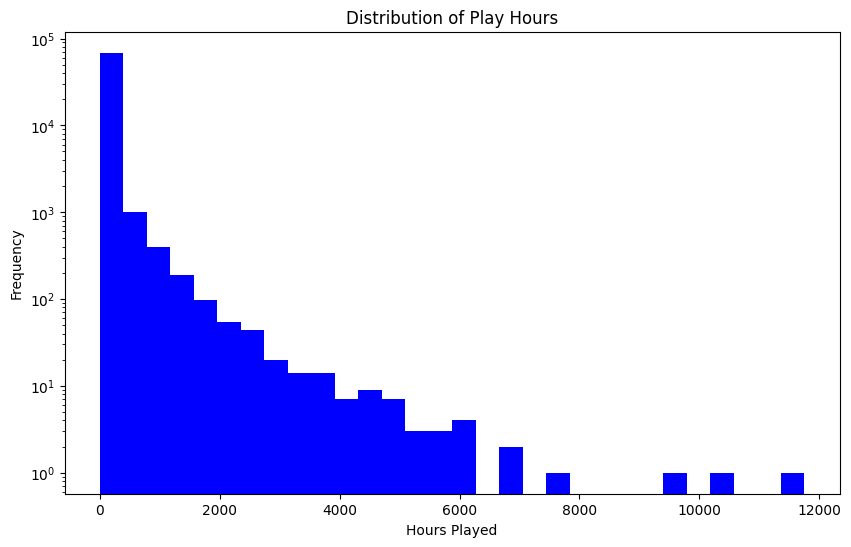

In [0]:
play_hours_list = [row['Value'] for row in play_hours_df.collect()]


import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
plt.hist(play_hours_list, bins=30, color='blue', log=True)  # Using log scale on y-axis
plt.title('Distribution of Play Hours')
plt.xlabel('Hours Played')
plt.ylabel('Frequency')
plt.show()


Evaluation of Recommendations

In [0]:
# Sample another user with play records
user_with_data = steam_data.filter(col("Behavior") == "play").select("UserID").distinct().limit(1)
user_with_data.show()

# Assuming you fetch the UserID like this
user_id = user_with_data.collect()[0]["UserID"]

# Get recommendations for this user
specific_user_recs = user_recs.filter(col("UserID") == user_id) \
                              .selectExpr("explode(recommendations) as recs") \
                              .select("recs.*")
specific_user_recs.show()


+--------+
|  UserID|
+--------+
|46055854|
+--------+

+------+---------+
|GameID|   rating|
+------+---------+
|  1761|1159.7812|
|  2020|1071.3607|
|  3648| 1032.358|
|  3251| 952.7469|
|  1880| 892.6552|
|   874| 837.2665|
|  1459| 832.0867|
|  4113| 810.4708|
|  3272| 766.7047|
|  1025|720.95575|
+------+---------+



In [0]:
# Analyze the distribution of play records
play_record_distribution = steam_data.filter(col("Behavior") == "play") \
                                     .groupBy("UserID").count().orderBy("count", ascending=False)
play_record_distribution.show()


+--------+-----+
|  UserID|count|
+--------+-----+
|46055854|    1|
|86055705|    1|
|93030550|    1|
+--------+-----+



ML Flow Experiment

In [0]:
import mlflow
import mlflow.spark
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.session import SparkSession

In [0]:
# Set up MLflow to log to a Databricks workspace
mlflow.set_experiment('/Users/v.l.kopparthi@edu.salford.ac.uk/ALS_Model_Experiment')

<Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/968228670151795', creation_time=1714576601721, experiment_id='968228670151795', last_update_time=1714576601721, lifecycle_stage='active', name='/Users/v.l.kopparthi@edu.salford.ac.uk/ALS_Model_Experiment', tags={'mlflow.experiment.sourceName': '/Users/v.l.kopparthi@edu.salford.ac.uk/ALS_Model_Experiment',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'v.l.kopparthi@edu.salford.ac.uk',
 'mlflow.ownerId': '6267631847599401'}>

In [0]:
def train_als(rank, maxIter, regParam, train, test):
    with mlflow.start_run():
        # Log parameters
        mlflow.log_param("rank", rank)
        mlflow.log_param("maxIter", maxIter)
        mlflow.log_param("regParam", regParam)
        
        # Create ALS model
        als = ALS(rank=rank, maxIter=maxIter, regParam=regParam, userCol="UserID", itemCol="GameID", ratingCol="Value", nonnegative=True)
        model = als.fit(train)

        # Evaluate the model
        predictions = model.transform(test)
        evaluator = RegressionEvaluator(metricName="rmse", labelCol="Value", predictionCol="prediction")
        rmse = evaluator.evaluate(predictions.na.drop())  # Ensure to drop any NaN predictions
        
        # Log metrics
        mlflow.log_metric("rmse", rmse)
        
        # Log model
        mlflow.spark.log_model(model, "model")
        
        return rmse

In [0]:
rmse_scores = []
rmse_scores.append(train_als(10, 5, 0.01, train, test))
rmse_scores.append(train_als(20, 10, 0.05, train, test))

2024/05/01 16:18:41 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().
2024/05/01 16:19:14 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: dbfs:/databricks/mlflow-tracking/968228670151795/56667426f86e4525afdeff225b9a45cd/artifacts/model/sparkml, flavor: spark). Fall back to return ['pyspark==3.5.1']. Set logging level to DEBUG to see the full traceback. 
/databricks/python/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/05/01 16:20:09 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env